# Building Classification Models with Embeddings

## Dependencies and Data


### Dependencies

In [1]:
#!pip install opencv-python
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import gzip
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from google.colab import drive
from google.colab import files

import cv2
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets, models
from torchvision.models import alexnet, AlexNet_Weights, vgg16, VGG16_Weights, resnet18, ResNet18_Weights
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler
import torch.optim as optim

from sklearn.model_selection import train_test_split
import shutil

### Get embeddings from GitHub

In [2]:
# download data from GitHub
!wget -O alexnet_train.zip https://github.com/haydenratliff/Stata-Navigation/raw/main/embeddings/alexnet_embeddings_train.csv.zip
!wget -O alexnet_val.zip https://github.com/haydenratliff/Stata-Navigation/raw/main/embeddings/alexnet_embeddings_val.csv.zip
!wget -O alexnet_test.zip https://github.com/haydenratliff/Stata-Navigation/raw/main/embeddings/alexnet_embeddings_test.csv.zip
!wget -O resnet_train.zip https://github.com/haydenratliff/Stata-Navigation/raw/main/embeddings/resnet_embeddings_train.csv.zip
!wget -O resnet_val.zip https://github.com/haydenratliff/Stata-Navigation/raw/main/embeddings/resnet_embeddings_val.csv.zip
!wget -O resnet_test.zip https://github.com/haydenratliff/Stata-Navigation/raw/main/embeddings/resnet_embeddings_test.csv.zip
!wget -O vgg_train.zip https://github.com/haydenratliff/Stata-Navigation/raw/main/embeddings/vgg_embeddings_train.csv.zip
!wget -O vgg_val.zip https://github.com/haydenratliff/Stata-Navigation/raw/main/embeddings/vgg_embeddings_val.csv.zip
!wget -O vgg_test.zip https://github.com/haydenratliff/Stata-Navigation/raw/main/embeddings/vgg_embeddings_test.csv.zip

# unzip all data
!unzip alexnet_train.zip
!unzip alexnet_val.zip
!unzip alexnet_test.zip
!unzip resnet_train.zip
!unzip resnet_val.zip
!unzip resnet_test.zip
!unzip vgg_train.zip
!unzip vgg_val.zip
!unzip vgg_test.zip

--2024-05-13 20:01:20--  https://github.com/haydenratliff/Stata-Navigation/raw/main/embeddings/alexnet_embeddings_train.csv.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/haydenratliff/Stata-Navigation/main/embeddings/alexnet_embeddings_train.csv.zip [following]
--2024-05-13 20:01:21--  https://raw.githubusercontent.com/haydenratliff/Stata-Navigation/main/embeddings/alexnet_embeddings_train.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30303055 (29M) [application/zip]
Saving to: ‘alexnet_train.zip’

alexnet_train.zip   100%[===================>]  28.90M  89.8MB/s    in 0.3s   

In [3]:
# load all data into pandas
alexnet_train = pd.read_csv("alexnet_embeddings_train.csv")
alexnet_val = pd.read_csv("alexnet_embeddings_val.csv")
alexnet_test = pd.read_csv("alexnet_embeddings_test.csv")
resnet_train = pd.read_csv("resnet_embeddings_train.csv")
resnet_val = pd.read_csv("resnet_embeddings_val.csv")
resnet_test = pd.read_csv("resnet_embeddings_test.csv")
vgg_train = pd.read_csv("vgg_embeddings_train.csv")
vgg_val = pd.read_csv("vgg_embeddings_val.csv")
vgg_test = pd.read_csv("vgg_embeddings_test.csv")

# split into embeddings table and labels np array
alexnet_train_embeddings = alexnet_train.drop(["label"], axis=1).values
alexnet_train_labels = alexnet_train["label"].values
alexnet_val_embeddings = alexnet_val.drop(["label"], axis=1).values
alexnet_val_labels = alexnet_val["label"].values
alexnet_test_embeddings = alexnet_test.drop(["label"], axis=1).values
alexnet_test_labels = alexnet_test["label"].values

resnet_train_embeddings = resnet_train.drop(["label"], axis=1).values
resnet_train_labels = resnet_train["label"].values
resnet_val_embeddings = resnet_val.drop(["label"], axis=1).values
resnet_val_labels = resnet_val["label"].values
resnet_test_embeddings = resnet_test.drop(["label"], axis=1).values
resnet_test_labels = resnet_test["label"].values

vgg_train_embeddings = vgg_train.drop(["label"], axis=1).values
vgg_train_labels = vgg_train["label"].values
vgg_val_embeddings = vgg_val.drop(["label"], axis=1).values
vgg_val_labels = vgg_val["label"].values
vgg_test_embeddings = vgg_test.drop(["label"], axis=1).values
vgg_test_labels = vgg_test["label"].values

### Convert to torch dataloader

In [4]:
def get_dataloader(data, labels, batch_size=32, shuffle=True):
  # convert from numpy arrays to tensor dataloaders compatible with torch training loop
    torch.manual_seed(2024)
    embeddings = torch.tensor(data, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.long)
    dataset = TensorDataset(embeddings, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

# get dataloaders for each model's embeddings
alexnet_train_dataloader = get_dataloader(alexnet_train_embeddings, alexnet_train_labels)
alexnet_val_dataloader = get_dataloader(alexnet_val_embeddings, alexnet_val_labels)
alexnet_test_dataloader = get_dataloader(alexnet_test_embeddings, alexnet_test_labels, shuffle=False)
resnet_train_dataloader = get_dataloader(resnet_train_embeddings, resnet_train_labels)
resnet_val_dataloader = get_dataloader(resnet_val_embeddings, resnet_val_labels)
resnet_test_dataloader = get_dataloader(resnet_test_embeddings, resnet_test_labels, shuffle=False)
vgg_train_dataloader = get_dataloader(vgg_train_embeddings, vgg_train_labels)
vgg_val_dataloader = get_dataloader(vgg_val_embeddings, vgg_val_labels)
vgg_test_dataloader = get_dataloader(vgg_test_embeddings, vgg_test_labels, shuffle=False)

## Torch Training Functions

### Distance calculation

In [5]:
# copied from Krish's code

# Pixels to Feet
ptf = 32/(228-161)

# Due North
x1 = 740
y1 = 1208 - 1139
x2 = 746
y2 = 1208 - 1115
dx = x2 - x1
dy = y2 - y1
north = math.degrees(math.atan2(dy, dx))

# image is 1092 x 1208
label_dict = {1 : [220,259],
              2 : [201,321],
              3 : [245,303],
              4 : [230,417],
              5 : [191,434],
              6 : [193,385],
              7 : [256,479],
              8 : [317,449],
              9 : [353,512],
              10 : [384,459],
              11 : [455,480],
              12 : [449,549],
              13 : [494,518],
              14 : [518,471],
              15 : [587,467],
              16 : [642,456],
              17 : [469,564],
              18 : [448,656],
              19 : [471,724],
              20 : [620,528],
              21 : [712,445],
              22 : [697,478],
              23 : [783,513],
              24 : [796,418],
              25 : [779,346],
              26 : [765,382],
              27 : [842,339],
              28 : [916,313],
              29 : [949,335],
              30 : [993,262],
              31 : [829,538],
              32 : [856,509],
              33 : [915,525],
              34 : [871,476],
              35 : [964,475],
              36 : [950,408],
              37 : [913,368],
              'dreyfoos elevators' : [201,321],
              'sprial staircase' : [230,417],
              'childcare center' : [256,479],
              'Room 123' : [408,528], # two entrances
              'Room 124' : [384,459],
              'Room 141' : [546,497],
              'Room 144' : [585,448], # two entrances
              'Room 155' : [743,498], # two entrances
              'Forbes Family Cafe' : [871,476],
              'gates elevators' : [783,376],
              'stairs to basement' : [631,512]}

# function to find out which cardinal direction corresponds to a heading
def heading_2_direction(heading):
  if (heading > (360-22.5)) & (heading < (22.5)):
    return 'N'
  elif (heading > (22.5)) & (heading < (90 - 22.5)):
    return 'NE'
  elif (heading > (90 - 22.5)) & (heading < (90 + 22.5)):
    return 'E'
  elif (heading > (90 + 22.5)) & (heading < (180 - 22.5)):
    return 'SE'
  elif (heading > (180 - 22.5)) & (heading < (180 + 22.5)):
    return 'S'
  elif (heading > (180 + 22.5)) & (heading < (270 - 22.5)):
    return 'SW'
  elif (heading > (270 - 22.5)) & (heading < (270 + 22.5)):
    return 'W'
  elif (heading > (270 + 22.5)) & (heading < (360-22.5)):
    return 'NW'

def all_values_in_dict(dictionary, values_list):
    return set(values_list).issubset(dictionary.keys())

# function to point folks in right direction
def which_way(start, end, orientation=-1):
  '''
    start: the start region of the navigator (as determined by the CV model)
    end: the desired destination of the navigator
    orientation: direction the user is facing at time of photo (optional input by the user),
     0 corresponds to due east and 90 is due north (think cartesian)
    '''
  # extract coordinates
  if all_values_in_dict(label_dict, [start, end]):
    x1 = label_dict[start][0] #x pixel coordinate of starting point
    y1 = 1208 - label_dict[start][1] #y pixel coordinate of starting point
    x2 = label_dict[end][0] #x pixel coordinate of end point
    y2 = 1208 - label_dict[end][1] #y pixel coordinate of end point
  else:
    print("Try different start and end destinations. Make sure they're in the labels list")
    return

  # find distance and angle
  dx = x2 - x1
  dy = y2 - y1
  angle_to_target = math.degrees(math.atan2(dy, dx))
  distance = math.sqrt(dx**2 + dy**2)

  # pixels to feet
  dist_in_feet = round(distance * ptf)

  # figure out which way to turn
  turn_needed = angle_to_target - orientation
  turn = round(turn_needed)
  print(turn_needed)
  left_right = 'left'
  if turn_needed < 0:
    turn_needed = -turn_needed
    left_right = 'right'
  print(turn_needed)
  if turn_needed > 180:
    turn_needed = 360 - turn_needed
    if left_right == 'right':
      left_right = 'left'
    else:
      left_right = 'right'
    print(turn_needed)

  # express as absolute heading
  heading = north - angle_to_target
  round_head = round(heading)
  direction = heading_2_direction(round_head)


  if orientation != -1:
    print(f"You must turn {turn} degrees to the {left_right} to face your destination")
  print(f"Alternatively, you can face {round_head} degrees {direction} using a compass")
  print(f"Your destination is {dist_in_feet} feet away from you")

def dist_in_feet(start, end):
    '''
    start: the start region of the navigator (as determined by the CV model)
    end: the desired destination of the navigator
    '''
    # extract coordinates
    if all_values_in_dict(label_dict, [start, end]):
      x1 = label_dict[start][0] #x pixel coordinate of starting point
      y1 = 1208 - label_dict[start][1] #y pixel coordinate of starting point
      x2 = label_dict[end][0] #x pixel coordinate of end point
      y2 = 1208 - label_dict[end][1] #y pixel coordinate of end point
    else:
      print("Try different start and end destinations. Make sure they're in the labels list")
      return

    # find distance and angle
    dx = x2 - x1
    dy = y2 - y1
    angle_to_target = math.degrees(math.atan2(dy, dx))
    distance = math.sqrt(dx**2 + dy**2)

    # pixels to feet
    dist_in_feet = round(distance * ptf)

    return dist_in_feet

In [6]:
def predict(model, test_loader):
    # extracts predictions on test set

    model.eval()
    pred = []

    # no gradient
    with torch.no_grad():
        for data, labels in test_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)

            pred = pred + predicted.tolist()

    return pred


def pred_distance(model, test_loader):
    # extracts distances between predicted and actual labels on the test set

    model.eval()
    dist = []

    # no gradient
    with torch.no_grad():
        for data, labels in test_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)

            # calculate distance using above function
            for i in range(len(predicted)):
                dist.append(dist_in_feet(predicted[i].item() + 1, labels[i].item() + 1))

    return dist

def histogram(data, bins=50, title="Histogram", xlabel="Prediction Distance", ylabel="Percent"):
    # simple histogram plotter

    weights = [100.0 / len(data)] * len(data)
    plt.figure(figsize=(8, 6))
    plt.hist(data, bins=bins, weights=weights, color='blue', alpha=0.7)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.gca().yaxis.set_major_formatter(PercentFormatter())
    plt.show()

### Torch training loop

In [7]:
def train(model, train_loader, val_loader, lr=0.001, num_epochs=10, save_path="model"):
    # torch training loop

    # set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # init loss fxn
    loss_fxn = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    num_batches = len(train_loader)

    for epoch in range(num_epochs):
        model.train()
        train_loss, val_loss = 0.0, 0.0

        train_total, train_correct = 0, 0
        train_distances = []

        # training
        for inputs, labels in tqdm(train_loader, total=num_batches, desc=f"Epoch {epoch+1}/{num_epochs}"):

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = loss_fxn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            for i in range(len(predicted)):
              train_distances.append(dist_in_feet(predicted[i].item() + 1, labels[i].item() + 1))

        # validation
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            val_distances = []
            for inputs, labels in val_loader:

                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)

                loss = loss_fxn(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                for i in range(len(predicted)):
                  val_distances.append(dist_in_feet(predicted[i].item() + 1, labels[i].item() + 1))

        train_loss = train_loss / len(train_loader)
        train_accuracy = train_correct / train_total
        train_avg_dist = sum(train_distances) / len(train_distances)
        val_loss = val_loss / len(val_loader)
        val_accuracy = correct / total
        val_avg_dist = sum(val_distances) / len(val_distances)

        # print status
        print(f'Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train Avg Distance: {train_avg_dist:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val Avg Distance: {val_avg_dist:.4f}')

        # Save the model
        torch.save(model.state_dict(), f'{save_path}_epoch_{epoch + 1}.pth')

In [8]:
def accuracy(model, test_loader):
    # evaluation mode, count number of currect
    model.eval()
    correct = 0
    total = 0

    # no gradient
    with torch.no_grad():
        for data, labels in test_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [9]:
def load_model(model_class, input_size, load_path):
    # function to load model from state dict
    model = model_class(input_size)
    model.load_state_dict(torch.load(load_path))
    model.eval()
    return model

## Custom torch models for embeddings

### Torch model code

In [15]:
# define torch model class
class Classifier(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_classes=37, dropout_rate=0.2):
        super(Classifier, self).__init__()

        # dropout layer, hidden layer, dropout layer, classification head
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

class ComplexClassifier(nn.Module):
    def __init__(self, input_size, hidden_1_size=256, hidden_size_2=128, num_classes=37, dropout_rate=0.2):
        super(ComplexClassifier, self).__init__()

        # dropout, hidden layers, batch normalization
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(input_size, hidden_1_size)
        self.bn1 = nn.BatchNorm1d(hidden_1_size)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_1_size, hidden_size_2)
        self.bn2 = nn.BatchNorm1d(hidden_size_2)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_size_2, num_classes)

    def forward(self, x):
        # use relu
        x = self.dropout1(x)
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.dropout2(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.dropout3(x)
        x = self.fc3(x)
        return x

# get input sizes for alexnet, resnet, vgg
alexnet_input_size = 4096
resnet_input_size = 512
vgg_input_size = 4096

### Resnet

In [ ]:
# train resnet model with embeddings
epochs = 10
lr = 0.001
resnet_embeddings_model = Classifier(resnet_input_size)
train(resnet_embeddings_model, resnet_train_dataloader, resnet_val_dataloader, lr=lr, num_epochs=epochs, save_path="resnet_model")

### Alexnet

In [ ]:
# train alexnet model with embeddings
epochs = 10
lr = 0.001
alexnet_embeddings_model = Classifier(alexnet_input_size)
train(alexnet_embeddings_model, alexnet_train_dataloader, alexnet_val_dataloader, lr=lr, num_epochs=epochs, save_path="alexnet_model")

### VGG

In [ ]:
# train vgg model with embeddings
epochs = 10
lr = 0.001
vgg_embeddings_model = Classifier(vgg_input_size)
train(vgg_embeddings_model, vgg_train_dataloader, vgg_val_dataloader, lr=lr, num_epochs=epochs, save_path="vgg_model")

### Resnet Complex

In [ ]:
# train resnet complex model with embeddings
epochs = 10
lr = 0.001
resnet_embeddings_model = ComplexClassifier(resnet_input_size)
train(resnet_embeddings_model, resnet_train_dataloader, resnet_val_dataloader, lr=lr, num_epochs=epochs, save_path="resnet_model_complex")

### Alexnet Complex

In [ ]:
# train alexnet model with embeddings
epochs = 10
lr = 0.001
alexnet_embeddings_model = ComplexClassifier(alexnet_input_size)
train(alexnet_embeddings_model, alexnet_train_dataloader, alexnet_val_dataloader, lr=lr, num_epochs=epochs, save_path="alexnet_model_complex")

### VGG Complex

In [ ]:
# train vgg model with embeddings
epochs = 10
lr = 0.001
vgg_embeddings_model = ComplexClassifier(vgg_input_size)
train(vgg_embeddings_model, vgg_train_dataloader, vgg_val_dataloader, lr=lr, num_epochs=epochs, save_path="vgg_model_complex")

## Download / load model checkpoints

### Download model checkpoints

In [ ]:
# for simple models
model_names = ["resnet", "alexnet", "vgg"]
for model in model_names:
  for i in range(epochs):
    files.download(f"{model}_model_epoch_{i+1}.pth")

In [ ]:
# for simple models
model_names = ["resnet", "alexnet", "vgg"]
for model in model_names:
  for i in range(epochs):
    files.download(f"{model}_model_complex_epoch_{i+1}.pth")

### Load model checkpoints from GitHub

In [12]:
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/resnet/resnet_model_epoch_1.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/resnet/resnet_model_epoch_2.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/resnet/resnet_model_epoch_3.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/resnet/resnet_model_epoch_4.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/resnet/resnet_model_epoch_5.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/resnet/resnet_model_epoch_6.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/resnet/resnet_model_epoch_7.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/resnet/resnet_model_epoch_8.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/resnet/resnet_model_epoch_9.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/resnet/resnet_model_epoch_10.pth

!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/alexnet/alexnet_model_epoch_1.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/alexnet/alexnet_model_epoch_2.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/alexnet/alexnet_model_epoch_3.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/alexnet/alexnet_model_epoch_4.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/alexnet/alexnet_model_epoch_5.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/alexnet/alexnet_model_epoch_6.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/alexnet/alexnet_model_epoch_7.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/alexnet/alexnet_model_epoch_8.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/alexnet/alexnet_model_epoch_9.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/alexnet/alexnet_model_epoch_10.pth

!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/vgg/vgg_model_epoch_1.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/vgg/vgg_model_epoch_2.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/vgg/vgg_model_epoch_3.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/vgg/vgg_model_epoch_4.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/vgg/vgg_model_epoch_5.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/vgg/vgg_model_epoch_6.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/vgg/vgg_model_epoch_7.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/vgg/vgg_model_epoch_8.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/vgg/vgg_model_epoch_9.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/vgg/vgg_model_epoch_10.pth

!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/resnet_complex/resnet_model_complex_epoch_1.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/resnet_complex/resnet_model_complex_epoch_2.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/resnet_complex/resnet_model_complex_epoch_3.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/resnet_complex/resnet_model_complex_epoch_4.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/resnet_complex/resnet_model_complex_epoch_5.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/resnet_complex/resnet_model_complex_epoch_6.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/resnet_complex/resnet_model_complex_epoch_7.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/resnet_complex/resnet_model_complex_epoch_8.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/resnet_complex/resnet_model_complex_epoch_9.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/resnet_complex/resnet_model_complex_epoch_10.pth

!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/alexnet_complex/alexnet_model_complex_epoch_1.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/alexnet_complex/alexnet_model_complex_epoch_2.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/alexnet_complex/alexnet_model_complex_epoch_3.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/alexnet_complex/alexnet_model_complex_epoch_4.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/alexnet_complex/alexnet_model_complex_epoch_5.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/alexnet_complex/alexnet_model_complex_epoch_6.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/alexnet_complex/alexnet_model_complex_epoch_7.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/alexnet_complex/alexnet_model_complex_epoch_8.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/alexnet_complex/alexnet_model_complex_epoch_9.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/alexnet_complex/alexnet_model_complex_epoch_10.pth

!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/vgg_complex/vgg_model_complex_epoch_1.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/vgg_complex/vgg_model_complex_epoch_2.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/vgg_complex/vgg_model_complex_epoch_3.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/vgg_complex/vgg_model_complex_epoch_4.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/vgg_complex/vgg_model_complex_epoch_5.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/vgg_complex/vgg_model_complex_epoch_6.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/vgg_complex/vgg_model_complex_epoch_7.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/vgg_complex/vgg_model_complex_epoch_8.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/vgg_complex/vgg_model_complex_epoch_9.pth
!wget https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/vgg_complex/vgg_model_complex_epoch_10.pth

--2024-05-13 20:02:14--  https://github.com/haydenratliff/Stata-Navigation/raw/main/model_checkpoints/resnet/resnet_model_epoch_1.pth
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/haydenratliff/Stata-Navigation/main/model_checkpoints/resnet/resnet_model_epoch_1.pth [following]
--2024-05-13 20:02:14--  https://raw.githubusercontent.com/haydenratliff/Stata-Navigation/main/model_checkpoints/resnet/resnet_model_epoch_1.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 283960 (277K) [application/octet-stream]
Saving to: ‘resnet_model_epoch_1.pth’

resnet_model_epoch_ 100%[===================>

## Model evaluation

### Test set accuracy

In [43]:
# load best models
resnet_final_model_path = "resnet_model_epoch_10.pth"
alexnet_final_model_path = "alexnet_model_epoch_2.pth"
vgg_final_model_path = "vgg_model_epoch_2.pth"
resnet_complex_final_model_path = "resnet_model_complex_epoch_10.pth"
alexnet_complex_final_model_path = "alexnet_model_complex_epoch_10.pth"
vgg_complex_final_model_path = "vgg_model_complex_epoch_2.pth"

resnet_final_model = load_model(Classifier, resnet_input_size, resnet_final_model_path)
alexnet_final_model = load_model(Classifier, alexnet_input_size, alexnet_final_model_path)
vgg_final_model = load_model(Classifier, vgg_input_size, vgg_final_model_path)
resnet_complex_final_model = load_model(ComplexClassifier, resnet_input_size, resnet_complex_final_model_path)
alexnet_complex_final_model = load_model(ComplexClassifier, alexnet_input_size, alexnet_complex_final_model_path)
vgg_complex_final_model = load_model(ComplexClassifier, vgg_input_size, vgg_complex_final_model_path)

In [44]:
# test set accuracy
resnet_test_accuracy = accuracy(resnet_final_model, resnet_test_dataloader)
alexnet_test_accuracy = accuracy(alexnet_final_model, alexnet_test_dataloader)
vgg_test_accuracy = accuracy(vgg_final_model, vgg_test_dataloader)
28
resnet_complex_test_accuracy = accuracy(resnet_complex_final_model, resnet_test_dataloader)
alexnet_complex_test_accuracy = accuracy(alexnet_complex_final_model, alexnet_test_dataloader)
vgg_complex_test_accuracy = accuracy(vgg_complex_final_model, vgg_test_dataloader)

print(f"Resnet Test Accuracy: {resnet_test_accuracy:.4f}")
print(f"Alexnet Test Accuracy: {alexnet_test_accuracy:.4f}")
print(f"VGG Test Accuracy: {vgg_test_accuracy:.4f}")
print("")
print(f"Resnet Deeper Test Accuracy: {resnet_complex_test_accuracy:.4f}")
print(f"Alexnet Deeper Test Accuracy: {alexnet_complex_test_accuracy:.4f}")
print(f"VGG Deeper Test Accuracy: {vgg_complex_test_accuracy:.4f}")

Resnet Test Accuracy: 0.4054
Alexnet Test Accuracy: 0.3405
VGG Test Accuracy: 0.3189

Resnet Deeper Test Accuracy: 0.4649
Alexnet Deeper Test Accuracy: 0.3568
VGG Deeper Test Accuracy: 0.3297


### Test set distances

In [47]:
# test set distance
resnet_distances = pred_distance(resnet_final_model, resnet_test_dataloader)
alexnet_distances = pred_distance(alexnet_final_model, alexnet_test_dataloader)
vgg_distances = pred_distance(vgg_final_model, vgg_test_dataloader)

resnet_complex_distances = pred_distance(resnet_complex_final_model, resnet_test_dataloader)
alexnet_complex_distances = pred_distance(alexnet_complex_final_model, alexnet_test_dataloader)
vgg_complex_distances = pred_distance(vgg_complex_final_model, vgg_test_dataloader)

print(f"Resnet Average Pred Distance: {round(sum(resnet_distances) / len(resnet_distances), 2)}; Median: {np.median(resnet_distances)}; Max: {max(resnet_distances)}")
print(f"Alexnet Average Pred Distance: {round(sum(alexnet_distances) / len(alexnet_distances), 2)}; Median: {np.median(alexnet_distances)}; Max: {max(alexnet_distances)}")
print(f"VGG Average Pred Distance: {round(sum(vgg_distances) / len(vgg_distances), 2)}; Median: {np.median(vgg_distances)}; Max: {max(vgg_distances)}")
print("")
print(f"Resnet Deeper Average Pred Distance: {round(sum(resnet_complex_distances) / len(resnet_complex_distances), 2)}; Median: {np.median(resnet_complex_distances)}; Max: {max(resnet_complex_distances)}")
print(f"Alexnet Deeper Average Pred Distance: {round(sum(alexnet_complex_distances) / len(alexnet_complex_distances), 2)}; Median: {np.median(alexnet_complex_distances)}; Max: {max(alexnet_complex_distances)}")
print(f"VGG Deeper Average Pred Distance: {round(sum(vgg_complex_distances) / len(vgg_complex_distances), 2)}; Median: {np.median(vgg_complex_distances)}; Max: {max(vgg_complex_distances)}")

Resnet Average Pred Distance: 78.88; Median: 35.0; Max: 379
Alexnet Average Pred Distance: 88.64; Median: 53.0; Max: 360
VGG Average Pred Distance: 83.71; Median: 46.0; Max: 344

Resnet Deeper Average Pred Distance: 68.49; Median: 29.0; Max: 387
Alexnet Deeper Average Pred Distance: 89.72; Median: 46.0; Max: 360
VGG Deeper Average Pred Distance: 84.6; Median: 46.0; Max: 360


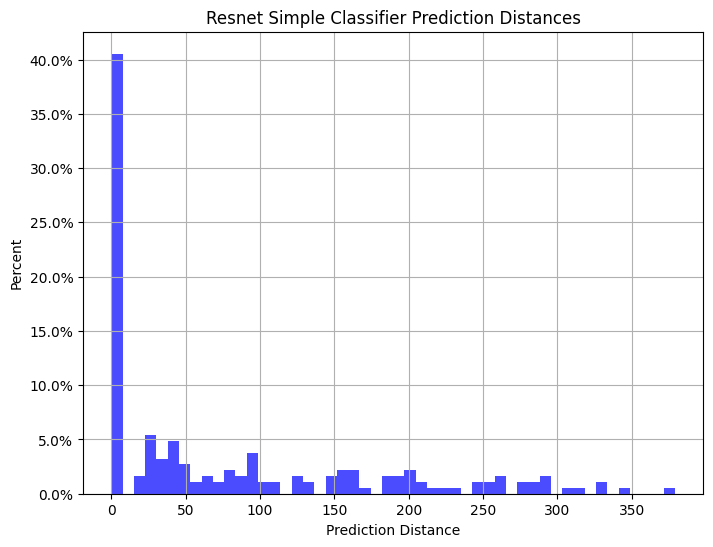

In [55]:
# resnet prediction distances
histogram(resnet_distances, title="Resnet Simple Classifier Prediction Distances")

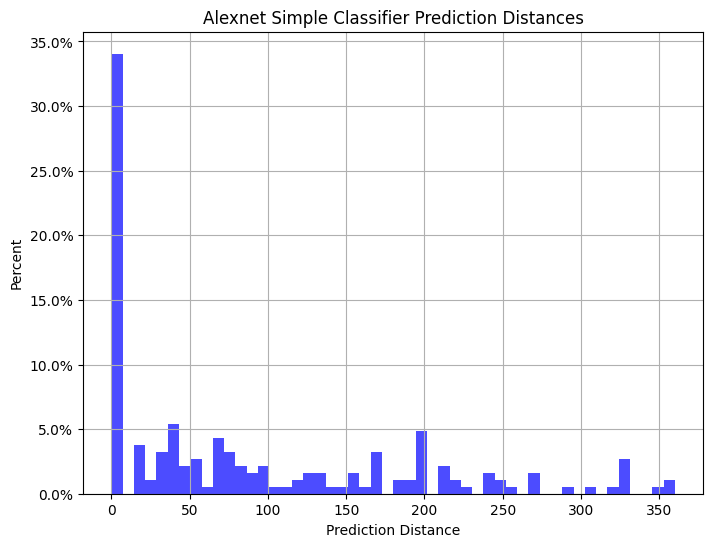

In [56]:
# resnet prediction distances
histogram(alexnet_distances, title="Alexnet Simple Classifier Prediction Distances")

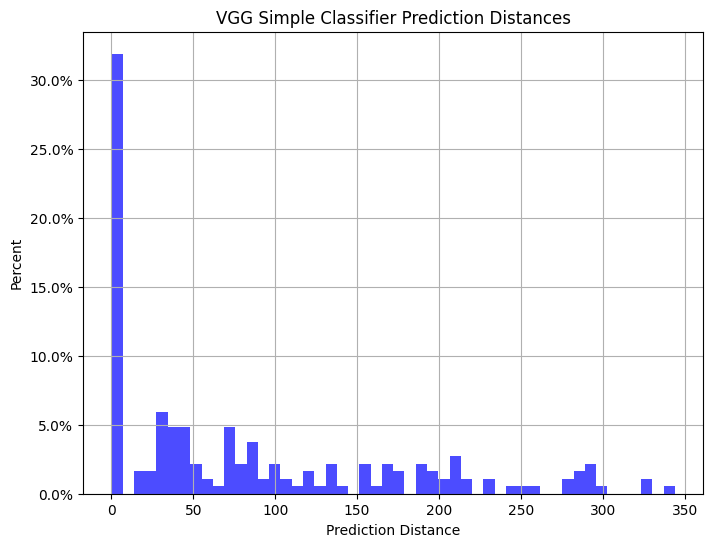

In [57]:
# resnet prediction distances
histogram(vgg_distances, title="VGG Simple Classifier Prediction Distances")

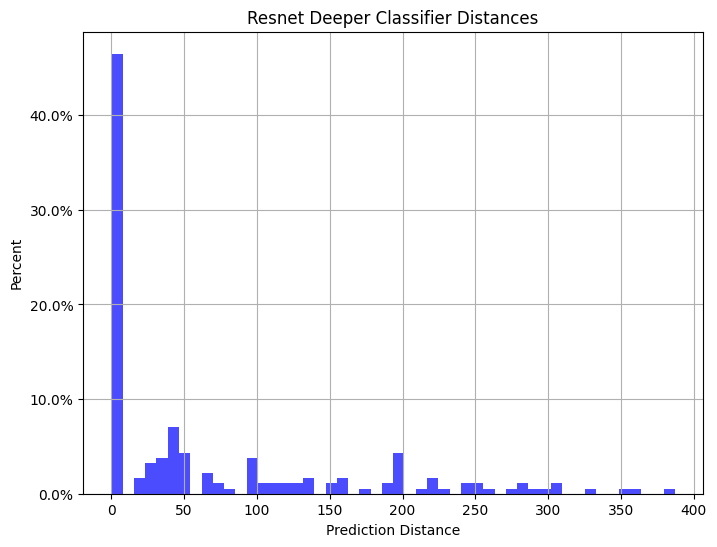

In [59]:
# resnet complex prediction distances
histogram(resnet_complex_distances, title="Resnet Deeper Classifier Distances")

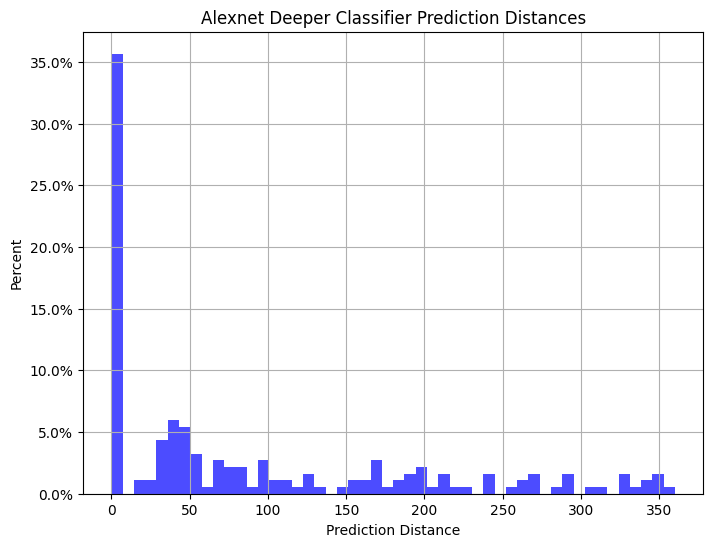

In [60]:
# alexnet complex prediction distances
histogram(alexnet_complex_distances, title="Alexnet Deeper Classifier Prediction Distances")

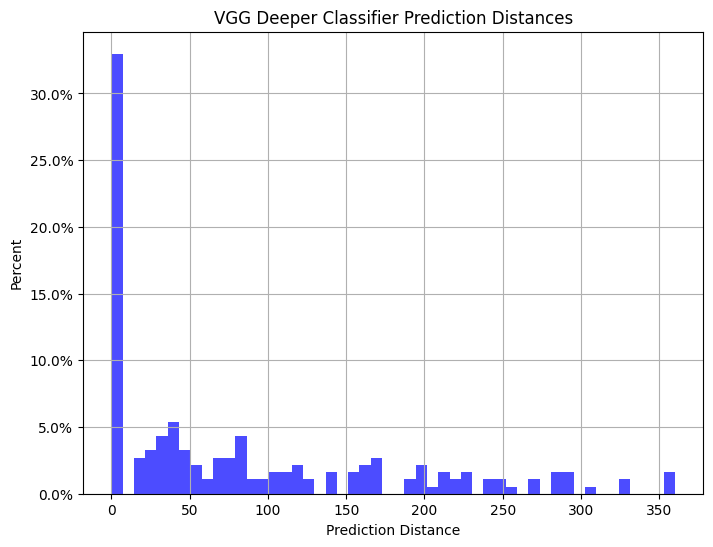

In [61]:
# vgg_complex prediction distances
histogram(vgg_complex_distances, title="VGG Deeper Classifier Prediction Distances")

### Test set in neighborhood

In [49]:
def percent_in_neighborhood(model, test_labels, test_dataloader, neighbors):
    # function to get the percent of predictions in the neighborhood of each location
    in_neighborhood = 0
    pred = predict(model, test_dataloader)

    for i in range(len(pred)):
      if pred[i] + 1 in neighbors[test_labels[i] + 1]:
        in_neighborhood += 1

    in_neighborhood_pct = in_neighborhood / len(pred)

    return in_neighborhood_pct

In [50]:
# build distance matrix
distance_matrix = np.zeros((37,37))
for i in range(37):
  for j in range(37):
    distance_matrix[i,j] = dist_in_feet(i+1, j+1)

# get neighbors of each location as 5 closest locations, excluding self
dist_sorted = np.argsort(distance_matrix, axis=1)
neighbors = {i+1: set([int(j+1) for j in dist_sorted[i,0:5]]) for i in range(37)}

In [51]:
# get neighborhood percents
resnet_neighborhood = percent_in_neighborhood(resnet_final_model, resnet_test_labels, resnet_test_dataloader, neighbors)
alexnet_neighborhood = percent_in_neighborhood(alexnet_final_model, alexnet_test_labels, alexnet_test_dataloader, neighbors)
vgg_neighborhood = percent_in_neighborhood(vgg_final_model, vgg_test_labels, vgg_test_dataloader, neighbors)

resnet_complex_neighborhood = percent_in_neighborhood(resnet_complex_final_model, resnet_test_labels, resnet_test_dataloader, neighbors)
alexnet_complex_neighborhood = percent_in_neighborhood(alexnet_complex_final_model, alexnet_test_labels, alexnet_test_dataloader, neighbors)
vgg_complex_neighborhood = percent_in_neighborhood(vgg_complex_final_model, vgg_test_labels, vgg_test_dataloader, neighbors)

print(f"Resnet Percent in Neighborhood: {resnet_neighborhood:.4f}")
print(f"Alexnet Percent in Neighborhood: {alexnet_neighborhood:.4f}")
print(f"VGG Percent in Neighborhood: {vgg_neighborhood:.4f}")
print("")
print(f"Resnet Deeper Percent in Neighborhood: {resnet_complex_neighborhood:.4f}")
print(f"Alexnet Deeper Percent in Neighborhood: {alexnet_complex_neighborhood:.4f}")
print(f"VGG Deeper Percent in Neighborhood: {vgg_complex_neighborhood:.4f}")

Resnet Percent in Neighborhood: 0.5730
Alexnet Percent in Neighborhood: 0.4973
VGG Percent in Neighborhood: 0.5189

Resnet Deeper Percent in Neighborhood: 0.6378
Alexnet Deeper Percent in Neighborhood: 0.5243
VGG Deeper Percent in Neighborhood: 0.5243
